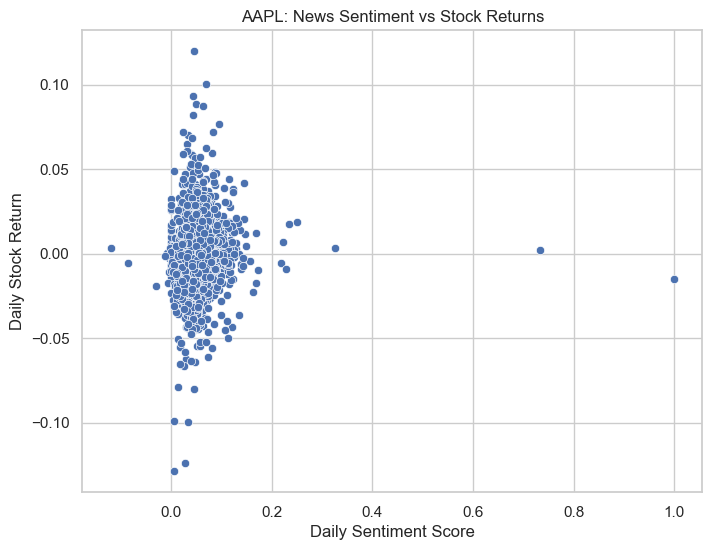

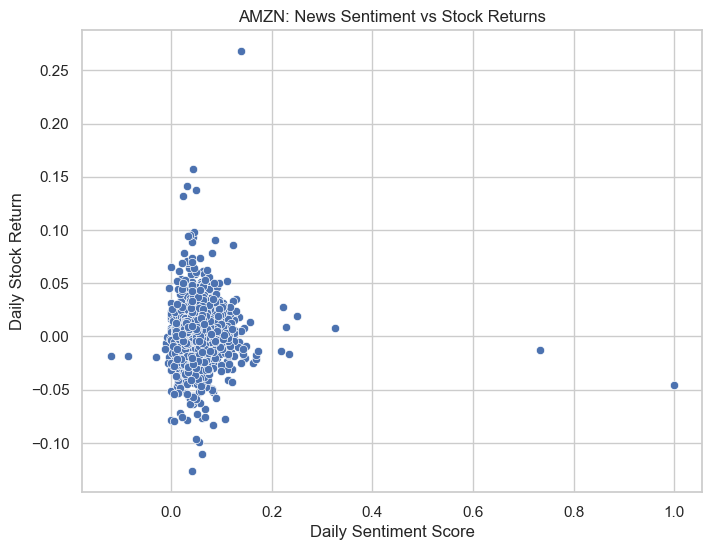

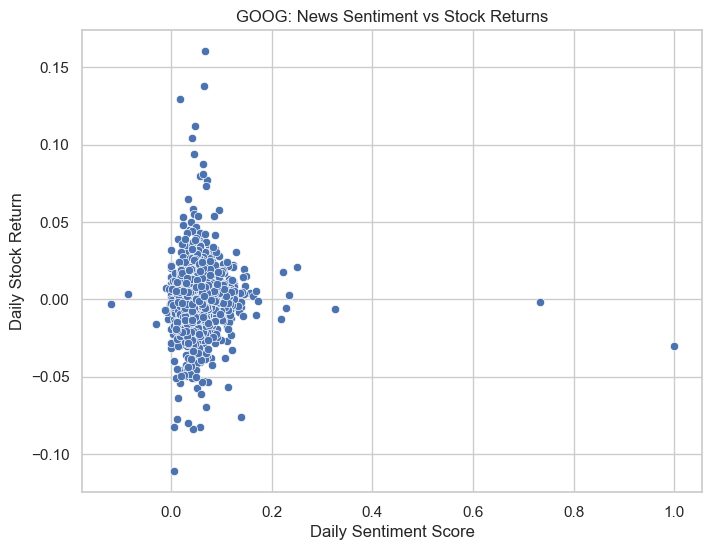

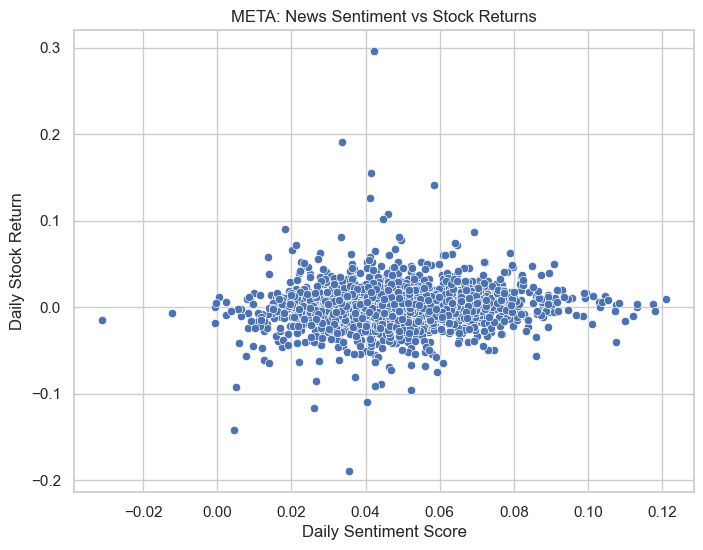

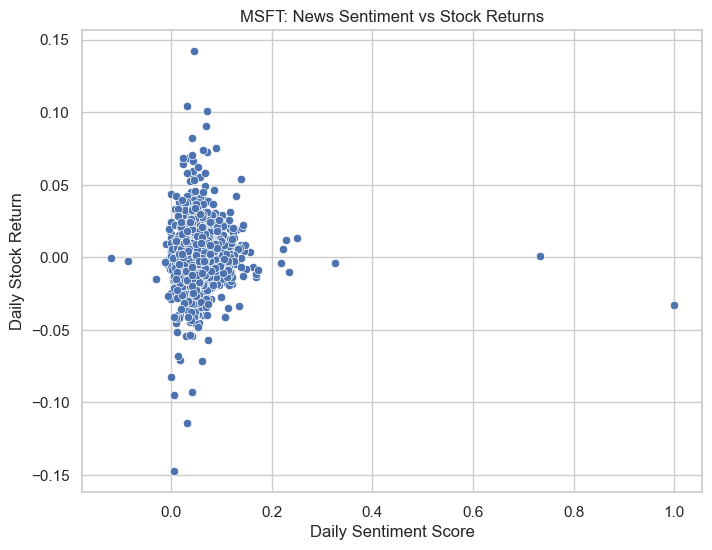

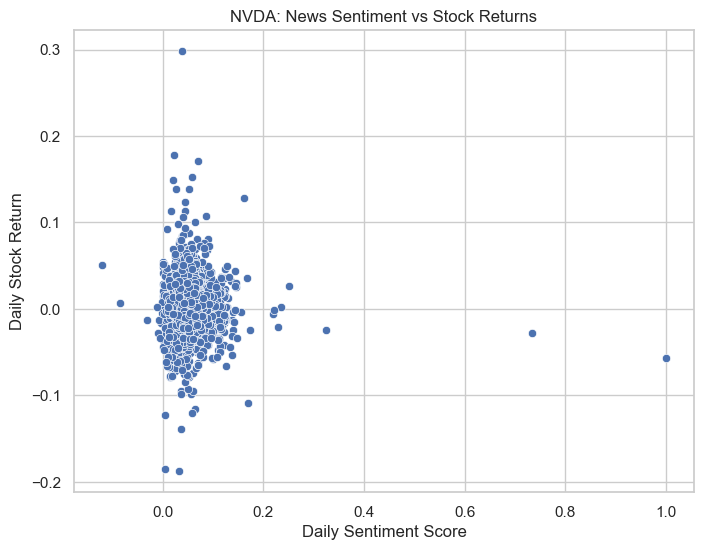


Correlation between News Sentiment and Stock Returns:
  Ticker  Correlation
0   AAPL     0.046374
1   AMZN     0.008085
2   GOOG     0.019263
3   META     0.086012
4   MSFT     0.036386
5   NVDA    -0.022416


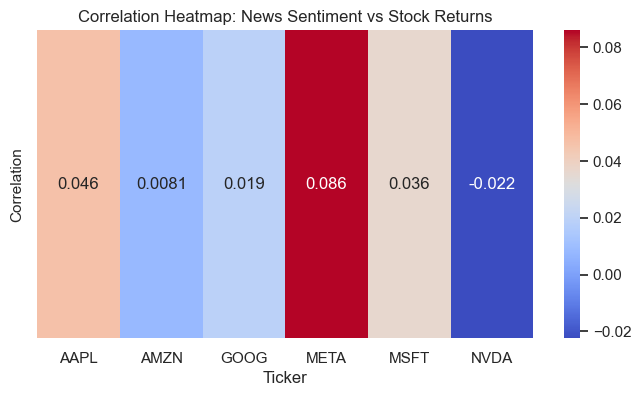

Correlation results exported to sentiment_stock_correlation.xlsx


In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


# Paths
data_dir = r"C:\Users\gasha\OneDrive - Wollo University\Desktop\10Academy AIM 8\fnspid\data"
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
news_file = f"{data_dir}\\raw_analyst_ratings.csv"

# ============================================
# 3. Load News Data
# ============================================
news_df = pd.read_csv(news_file)

# Detect date column
news_date_col = [col for col in news_df.columns if 'date' in col.lower()][0]

# Parse dates and remove timezone
news_df[news_date_col] = pd.to_datetime(news_df[news_date_col], errors='coerce', format='mixed', utc=True)
news_df[news_date_col] = news_df[news_date_col].dt.tz_localize(None)
news_df = news_df.dropna(subset=[news_date_col])

# Detect text column for sentiment
text_col = None
for col in news_df.columns:
    if any(keyword in col.lower() for keyword in ['headline', 'title', 'news', 'summary']):
        text_col = col
        break

if not text_col:
    raise KeyError(f"No text column found for sentiment analysis. Columns: {news_df.columns.tolist()}")

# Sentiment analysis
news_df['Sentiment'] = news_df[text_col].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Aggregate sentiment by date
daily_sentiment = news_df.groupby(news_date_col)['Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'Sentiment': 'Daily_Sentiment'}, inplace=True)

# ============================================
# 4. Process Each Ticker
# ============================================
correlation_results = []

for ticker in tickers:
    file_path = f"{data_dir}\\{ticker}.csv"
    stock_df = pd.read_csv(file_path)

    # Detect date column
    date_col = [col for col in stock_df.columns if col.lower() in ['date', 'datetime', 'timestamp']][0]

    # Parse dates and remove timezone
    stock_df[date_col] = pd.to_datetime(stock_df[date_col], errors='coerce')
    stock_df[date_col] = stock_df[date_col].dt.tz_localize(None)
    stock_df = stock_df.dropna(subset=[date_col])
    stock_df = stock_df.sort_values(date_col)
    stock_df.set_index(date_col, inplace=True)

    # Compute daily returns
    stock_df['Daily_Return'] = stock_df['Close'].pct_change()

    # Merge with sentiment
    merged_df = pd.merge(stock_df[['Daily_Return']], daily_sentiment,
                         left_index=True, right_on=news_date_col, how='inner')

    # Compute correlation
    corr = merged_df[['Daily_Return', 'Daily_Sentiment']].corr().iloc[0, 1]
    correlation_results.append({'Ticker': ticker, 'Correlation': corr})

    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Daily_Sentiment', y='Daily_Return', data=merged_df)
    plt.title(f"{ticker}: News Sentiment vs Stock Returns")
    plt.xlabel("Daily Sentiment Score")
    plt.ylabel("Daily Stock Return")
    plt.show()

# ============================================
# 5. Summary Table
# ============================================
correlation_df = pd.DataFrame(correlation_results)
print("\nCorrelation between News Sentiment and Stock Returns:")
print(correlation_df)

# Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_df.set_index('Ticker').T, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: News Sentiment vs Stock Returns")
plt.show()

# Export to Excel
correlation_df.to_excel("sentiment_stock_correlation.xlsx", index=False)
print("Correlation results exported to sentiment_stock_correlation.xlsx")
